In [7]:
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import Get_data as Gd
import copy

In [8]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cpu


In [9]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

In [10]:
train_set, length = Gd.get_all_data(folders[:-2])
print(train_set.shape, train_set.max(), train_set.min())
train_set = train_set[:, :, 0]
train_set = Gd.segment_data(train_set, length, step_size=5) # panelling
preprocessor = Gd.Preprocessor()
preprocessor.fit(train_set)
preprocessed_train_set = preprocessor.transform(train_set)

train_x = preprocessed_train_set[:, 0:5, :]
train_y = preprocessed_train_set[:, 5:, :]

(2800, 97149, 3) 85786.05705137363 -17261.215250123092


In [5]:
test_set, length = Gd.get_all_data(folders[-2:])
test_set = test_set[:, :, 0]
test_set = Gd.segment_data(test_set, length, step_size=5) # panelling
test_set_real = copy.deepcopy(test_set)
preprocessed_test_set = preprocessor.transform(test_set)


test_x = preprocessed_test_set[:, 0:5, :]
test_y = preprocessed_test_set[:, 5:, :]

test_real_x = test_set_real[:, 0:5, :]
test_real_y = test_set_real[:, 5:, :]

In [6]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, test_real_x.shape, test_real_y.shape)

(532, 5, 50) (532, 5, 50) (38, 5, 50) (38, 5, 50) (38, 5, 97149) (38, 5, 97149)


In [7]:
train_tenser_set = Gd.MyDataset(train_x, train_y)
test_tenser_set = Gd.MyDataset(test_x, test_y)
test_real_tenser_set = Gd.MyDataset(test_real_x, test_real_y)

In [8]:
train_loader = DataLoader(train_tenser_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_tenser_set, batch_size=1, shuffle=False)
test_real_loader = DataLoader(test_real_tenser_set, batch_size=1, shuffle=False)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.sigmoid = nn.Sigmoid()
        
        self.W_xi = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xf = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xo = nn.Linear(input_size, hidden_size, bias=True)
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xc = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True)
        
    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_size, device=device), torch.zeros(batch_size, self.hidden_size, device=device)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h_t, c_t = self.init_hidden(batch_size, x.device)
        for t in range(seq_len):
            x_t = x[:, t, :]
            i_t = self.sigmoid(self.W_xi(x_t)+self.W_hi(h_t))
            f_t = self.sigmoid(self.W_xf(x_t)+self.W_hf(h_t))
            o_t = self.sigmoid(self.W_xo(x_t)+self.W_ho(h_t))
            g_t = torch.tanh(self.W_xc(x_t)+self.W_hc(h_t))
            
            c_t = f_t*c_t+i_t*g_t
            h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t
            
        
        
        

In [10]:
class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = hidden_size
        
        self.sigmoid = nn.Sigmoid()
        
        self.W_xi = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xf = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xo = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True)
        
        self.W_xc = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True)
        
    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_size, device=device), torch.zeros(batch_size, self.hidden_size, device=device)
    
    def forward(self, x, expected_seq_len):
        batch_size = x.shape[0]
        h_t, c_t = self.init_hidden(batch_size, x.device)
        output = []
        for t in range(expected_seq_len):
            
            i_t = self.sigmoid(self.W_xi(x)+self.W_hi(h_t))
            f_t = self.sigmoid(self.W_xf(x)+self.W_hf(h_t))
            o_t = self.sigmoid(self.W_xo(x)+self.W_ho(h_t))
            g_t = torch.tanh(self.W_xc(x)+self.W_hc(h_t))
            
            c_t = f_t*c_t+i_t*g_t
            h_t = o_t * torch.tanh(c_t)
            
            output.append(h_t.unsqueeze(1))
        output = torch.cat(output, dim=1)
        return output
        

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Seq2Seq, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim
        
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(hidden_dim)
        self.linear = nn.Linear(hidden_dim, self.output_dim)
        
        self.relu = nn.ReLU()
    
    def forward(self, x, expected_seq_len = 5):
        h_t, _ = self.encoder(x)
        output = self.decoder(h_t, expected_seq_len)
        
        output = self.relu(self.linear(output))
        
        return output
        

In [12]:
from torchsummary import summary
model = Seq2Seq(input_dim=50, hidden_dim=100)
summary = summary(model, input_size=(1, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           5,100
            Linear-2                  [-1, 100]          10,100
           Sigmoid-3                  [-1, 100]               0
            Linear-4                  [-1, 100]           5,100
            Linear-5                  [-1, 100]          10,100
           Sigmoid-6                  [-1, 100]               0
            Linear-7                  [-1, 100]           5,100
            Linear-8                  [-1, 100]          10,100
           Sigmoid-9                  [-1, 100]               0
           Linear-10                  [-1, 100]           5,100
           Linear-11                  [-1, 100]          10,100
          Encoder-12     [[-1, 100], [-1, 100]]               0
           Linear-13                  [-1, 100]          10,100
           Linear-14                  [

In [13]:
def train(model, train_loader, optimizer, criterion, device, epochs=100):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x_1, y_1 = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x_1)
            loss = criterion(y_1, output)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {total_loss / len(train_loader)}')

In [14]:
device = "cuda"

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))
model = Seq2Seq(input_dim=50, hidden_dim=50).to(device)
optimizer = optim.Adam(model.parameters())

In [15]:
train(model, train_loader, optimizer, device=device, criterion=RMSELoss())

Epoch 1/100, train Loss: 0.9862002951127512
Epoch 2/100, train Loss: 0.9725529926794546
Epoch 3/100, train Loss: 0.9441303489384828
Epoch 4/100, train Loss: 0.9376490701127935
Epoch 5/100, train Loss: 0.9314992085651115
Epoch 6/100, train Loss: 0.928157060234635
Epoch 7/100, train Loss: 0.9324928455882602
Epoch 8/100, train Loss: 0.9300809370146857
Epoch 9/100, train Loss: 0.920996140550684
Epoch 10/100, train Loss: 0.9247112042374082
Epoch 11/100, train Loss: 0.9170547878300702
Epoch 12/100, train Loss: 0.9122135021068432
Epoch 13/100, train Loss: 0.9104224746977841
Epoch 14/100, train Loss: 0.9168732000721825
Epoch 15/100, train Loss: 0.9096159327913214
Epoch 16/100, train Loss: 0.9086258323104294
Epoch 17/100, train Loss: 0.9111395235414859
Epoch 18/100, train Loss: 0.9114668071269989
Epoch 19/100, train Loss: 0.9041708520165196
Epoch 20/100, train Loss: 0.9074312305008924
Epoch 21/100, train Loss: 0.9098146116292035
Epoch 22/100, train Loss: 0.9129525621732076
Epoch 23/100, train L

In [41]:
def test(model, test_loader, test_real_loader, criterion, preprocessor, device=device):
    model.eval()
    latent_err = 0
    recon_err = 0
    err_y = 0
    err_x = 0
    with torch.no_grad():
        for (x, y), (x_r, y_r) in zip(test_loader, test_real_loader):
            x, y, x_r, y_r = x.to(device), y.to(device), x_r.to(device), y_r.to(device)
            output = model(x)
            latent_err += criterion(y, output).item()
            
            recon_y = preprocessor.inverse_transform(y.cpu().detach().numpy())
            recon_x = preprocessor.inverse_transform(x.cpu().detach().numpy())
            recon_output = preprocessor.inverse_transform(output.cpu().detach().numpy())

            y_r_np = y_r.cpu().detach().numpy()
            x_r_np = x_r.cpu().detach().numpy()

            recon_err += mean_squared_error(y_r_np.squeeze(), recon_output.squeeze())
            err_y += mean_squared_error(y_r_np.squeeze(), recon_y.squeeze())
            err_x += mean_squared_error(x_r_np.squeeze(), recon_x.squeeze())
        
        return latent_err/len(test_loader), recon_err/len(test_real_loader), err_y/len(test_real_loader), err_x/len(test_real_loader)
            

In [42]:
test(model, test_loader, test_real_loader, criterion=RMSELoss(), preprocessor=preprocessor)

(1.9175297806137486,
 326.4003141102649,
 0.46117050721138647,
 0.4692292982545359)

In [46]:
input, _ = test_tenser_set[0, :, :]


In [61]:
def draw_pic(model, input, label, real_output, coords):
    output = model(input)

    print(output.shape, label.shape)
    recon_output = preprocessor.inverse_transform(output.detach().numpy()) # (5, 97149)
    recon_label = preprocessor.inverse_transform(label.detach().unsqueeze(0).numpy())
    
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_output[0, i, :], cmap='bwr')
    plt.show()
    plt.close()
    
    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_label[0, i, :], cmap='bwr')
    plt.show()
    plt.close()
    
    real = real_output.detach().numpy().squeeze()
    fig3, axs = plt.subplots(1, 5, figsize=(30, 6))
    
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real[i, :], cmap='bwr')
    plt.show()
    plt.close()
    


torch.Size([1, 5, 50]) torch.Size([5, 50])


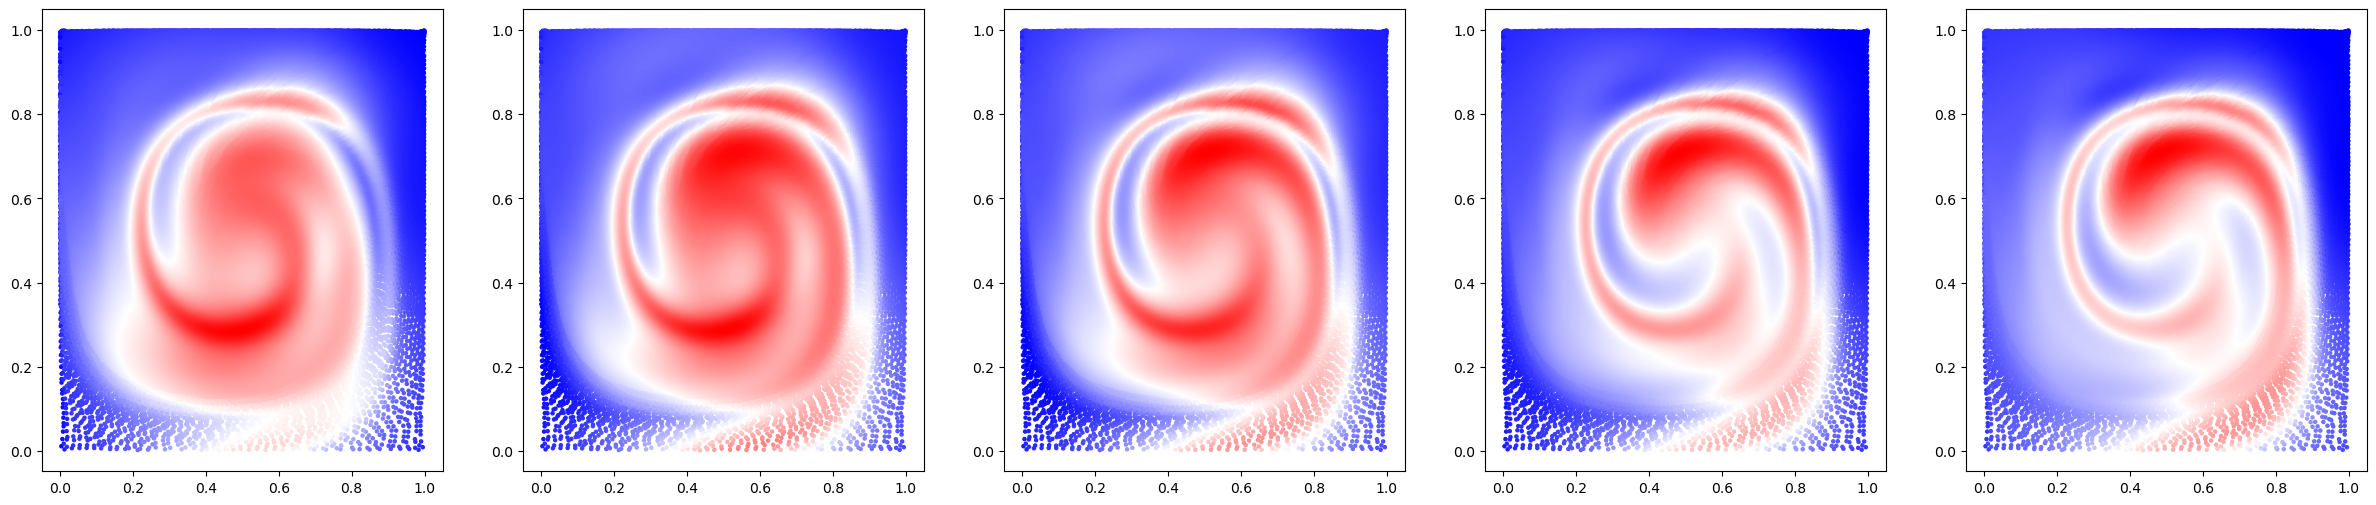

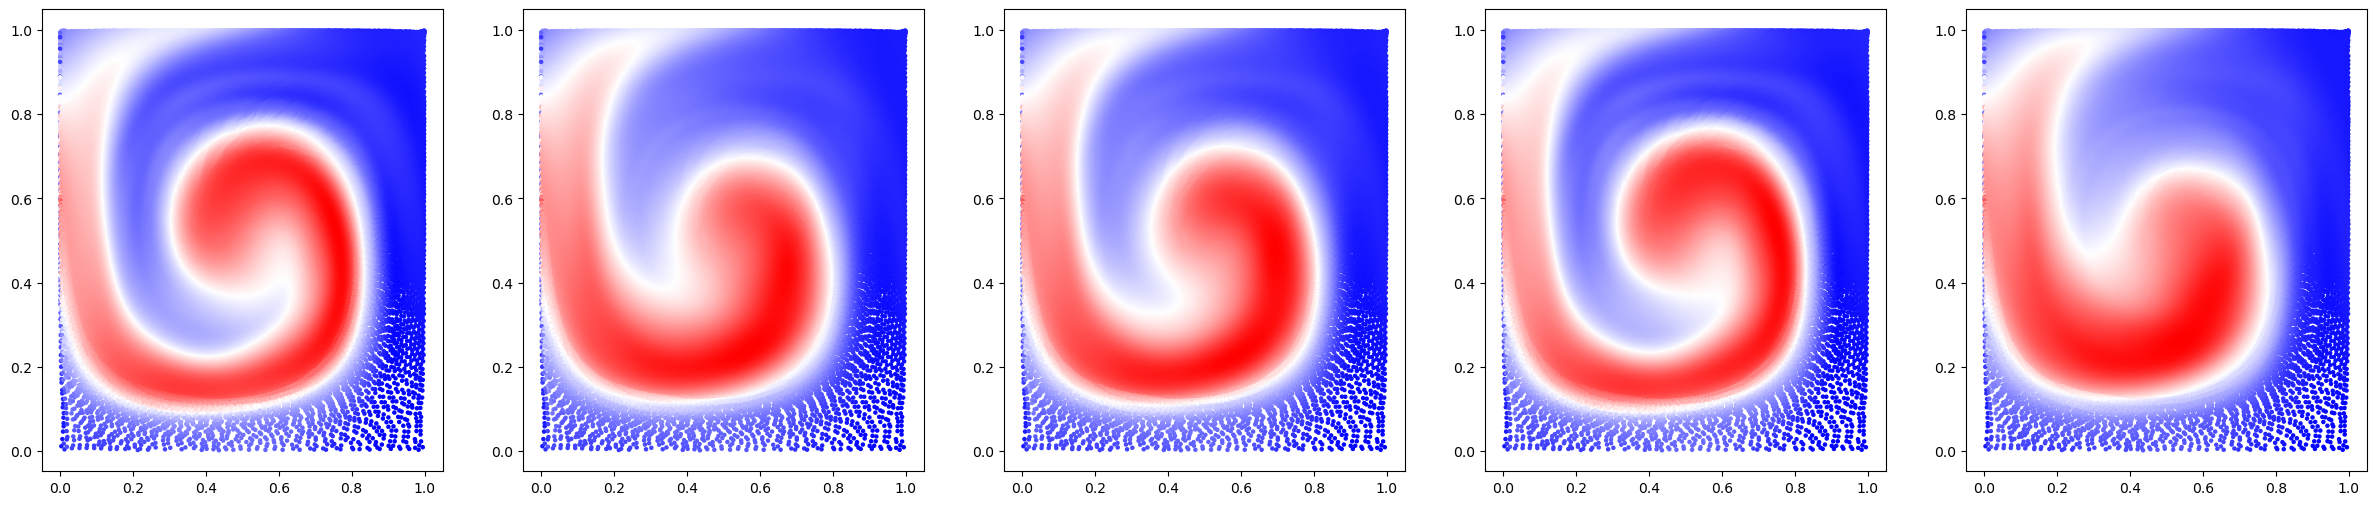

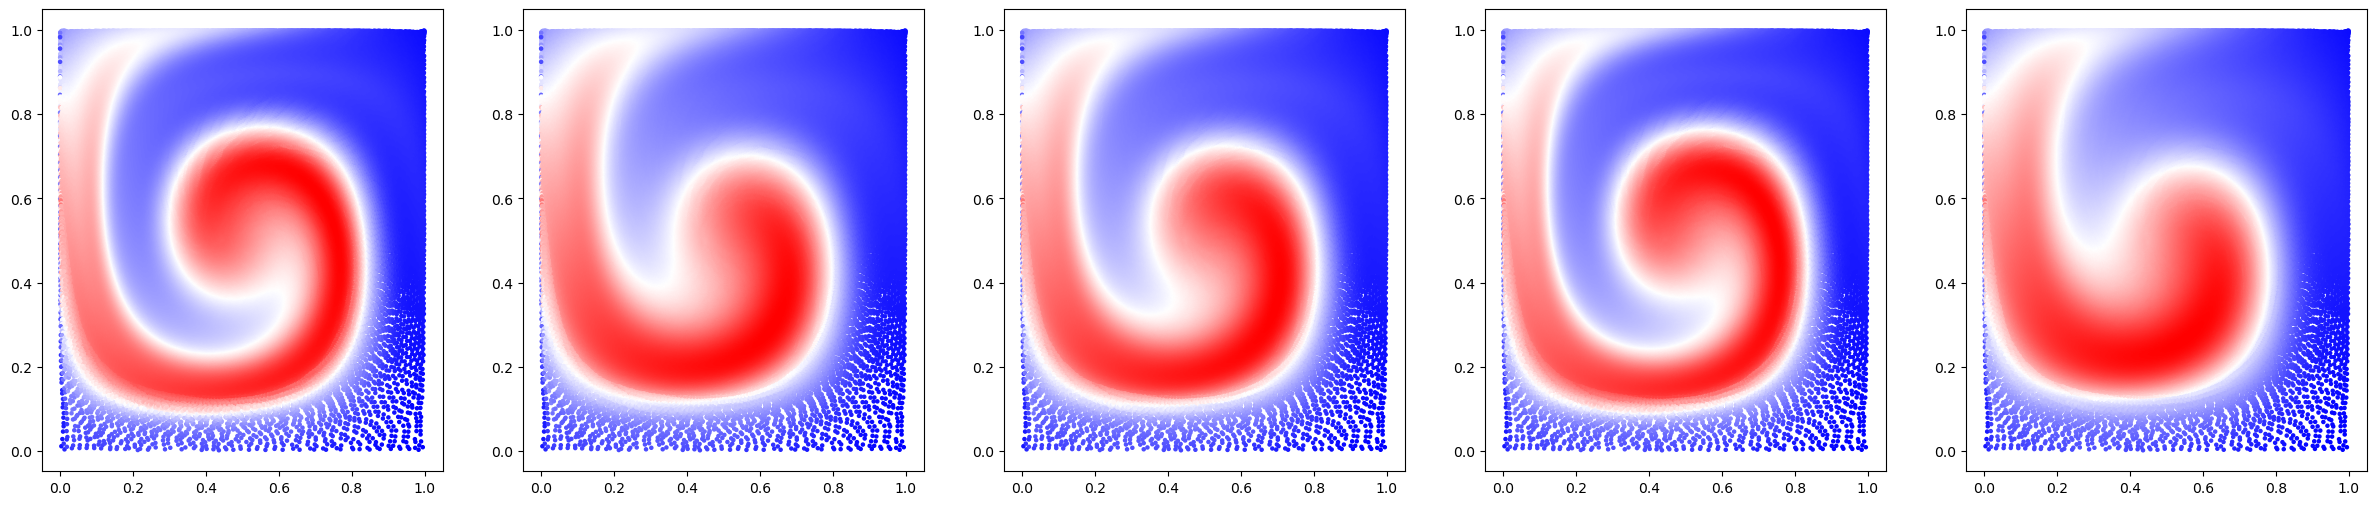

In [62]:

model.to("cpu")
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
marker_size = 5 #upped this to make points more visible
# load the file
xycoords_check = np.load(xyfile)

input, label = test_tenser_set[0, :, :]
input = input.unsqueeze(0)
_, real_output = test_real_tenser_set[0, :, :]
real_output = real_output.unsqueeze(0)

draw_pic(model, input, label, real_output, xycoords_check)

